In [2]:
from google.colab import files
import io

uploaded = files.upload()

Saving online_retail_II.csv to online_retail_II.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Konfigurasi agar tampilan tabel lebih rapi
pd.set_option('display.max_columns', None)

df = pd.read_csv('online_retail_II.csv')

print("Data Awal:")
df.info()
df.head()

Data Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# 1. Hapus baris yang Customer ID-nya kosong
df_clean = df.dropna(subset=['Customer ID'])

# 2. Hapus transaksi yang dibatalkan (Invoice mengandung huruf 'C')
# Ubah dulu kolom Invoice jadi string biar bisa dicek
df_clean['Invoice'] = df_clean['Invoice'].astype('str')
df_clean = df_clean[~df_clean['Invoice'].str.contains('C')]

# 3. Hapus data dengan Quantity atau Price <= 0
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]

print("Data Setelah Pembersihan:")
df_clean.info()

/tmp/ipython-input-1066545158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Invoice'] = df_clean['Invoice'].astype('str')


Data Setelah Pembersihan:
<class 'pandas.core.frame.DataFrame'>
Index: 805549 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      805549 non-null  object 
 1   StockCode    805549 non-null  object 
 2   Description  805549 non-null  object 
 3   Quantity     805549 non-null  int64  
 4   InvoiceDate  805549 non-null  object 
 5   Price        805549 non-null  float64
 6   Customer ID  805549 non-null  float64
 7   Country      805549 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 55.3+ MB


In [5]:
# Membuat kolom TotalPrice = Quantity * Price
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']

# Cek hasilnya
df_clean[['Quantity', 'Price', 'TotalPrice']].head()

,Quantity,Price,TotalPrice
0,12,6.95,83.4
1,12,6.75,81.0
2,12,6.75,81.0
3,48,2.10,100.8
4,24,1.25,30.0


In [6]:
# Ubah InvoiceDate jadi tipe datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Tentukan tanggal "Sekarang" (misal: 1 hari setelah transaksi terakhir di data)
present_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

print(f"Tanggal Referensi Analisis: {present_date}")

Tanggal Referensi Analisis: 2011-12-10 12:50:00


In [7]:
# Grouping data per Customer ID
rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (present_date - date.max()).days, # Hitung selisih hari (Recency)
    'Invoice': lambda num: num.nunique(), # Hitung jumlah invoice unik (Frequency)
    'TotalPrice': lambda price: price.sum() # Hitung total belanja (Monetary)
})

# Rename kolom biar lebih mudah dibaca
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Ubah tipe data Recency jadi integer
rfm['Recency'] = rfm['Recency'].astype(int)

print(rfm.head())

             Recency  Frequency  Monetary
Customer ID                              
12346.0          326         12  77556.46
12347.0            2          8   5633.32
12348.0           75          5   2019.40
12349.0           19          4   4428.69
12350.0          310          1    334.40


In [8]:
# Membuat label skor 1 sampai 5
r_labels = range(5, 0, -1) # Urutan terbalik untuk Recency
f_labels = range(1, 6)     # Urutan biasa untuk Frequency
m_labels = range(1, 6)     # Urutan biasa untuk Monetary

# Membagi data menjadi 5 bagian sama besar (Quantiles) dan memberi label
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=r_labels)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=f_labels)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=m_labels)

# Gabungkan skor jadi satu string (misal: "555" adalah pelanggan sempurna)
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print(rfm.head())

             Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
Customer ID                                                                
12346.0          326         12  77556.46       2       5       5       255
12347.0            2          8   5633.32       5       4       5       545
12348.0           75          5   2019.40       3       4       4       344
12349.0           19          4   4428.69       5       3       5       535
12350.0          310          1    334.40       2       1       2       212


In [9]:
# Fungsi untuk memberi nama segmen
def segment_customer(df):
    if df['RFM_Score'] == '555':
        return 'Champions (Raja)'
    elif df['R_Score'] == 5: # Baru belanja
        return 'Potential Loyalist'
    elif df['R_Score'] == 1: # Sudah lama gak belanja
        return 'Lost Customer'
    elif df['F_Score'] == 5: # Sering belanja
        return 'Loyal Customer'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Lihat sebaran segmen
print(rfm['Segment'].value_counts())

Segment
Others                2927
Lost Customer         1175
Potential Loyalist     714
Loyal Customer         588
Champions (Raja)       474
Name: count, dtype: int64


/tmp/ipython-input-495767653.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')


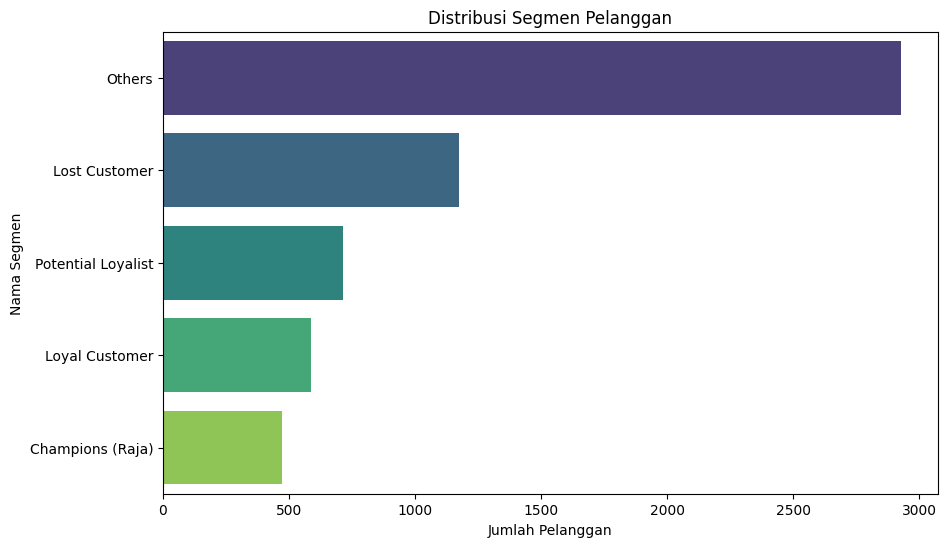

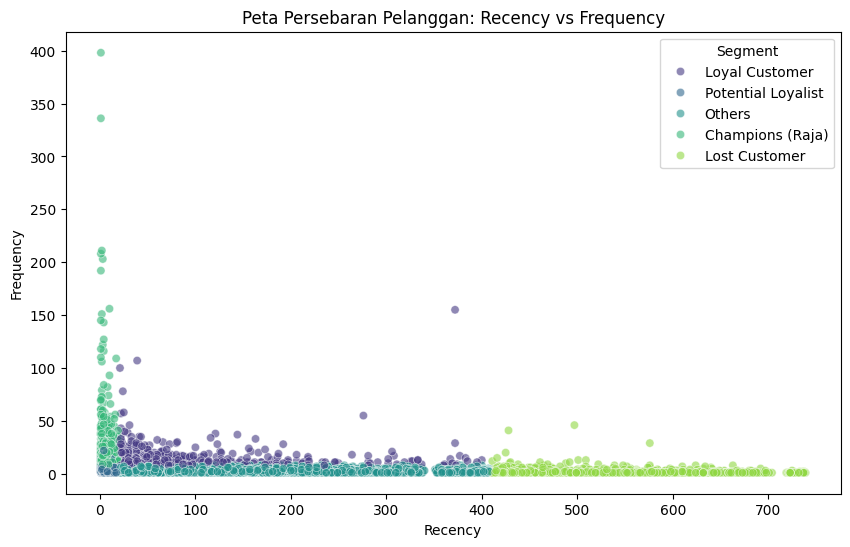

In [10]:
# Visualisasi jumlah customer per segmen
plt.figure(figsize=(10, 6))
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Distribusi Segmen Pelanggan')
plt.xlabel('Jumlah Pelanggan')
plt.ylabel('Nama Segmen')
plt.show()

# Visualisasi hubungan Recency vs Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=rfm, palette='viridis', alpha=0.6)
plt.title('Peta Persebaran Pelanggan: Recency vs Frequency')
plt.show()